# <h1><center>Feature Extraction 2.0</center></h1>

# Import pickels

In [1]:
# all import statements
import numpy as np
import pandas as pd
import pydicom as pyd
import os
import matplotlib.pyplot as plt
import mudicom

from os.path import dirname, join
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir
from PIL import Image

from scipy.misc import imresize
from scipy.signal import convolve2d
import scipy
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

from numpy import newaxis

In [2]:
import pickle

In [206]:
with open("DCM_NP", "rb") as fp:
    dcm = pickle.load(fp)

In [208]:
# dcm

In [6]:
with open("DCM-ADAHIST", "rb") as fp:
    dcm_adahist = pickle.load(fp)

In [7]:
with open("DCM-EQ", "rb") as fp:
    dcm_eq = pickle.load(fp)

In [8]:
!ls

2dconv.ipynb                  dcm_height
DCM                           dcm_target
DCM-ADAHIST                   dcm_width
DCM-EQ                        dcm_x
Data_Entry_2017.csv           dcm_y
FASTAI-1-RANDOM-FOREST.ipynb  include
FASTAI-3-GROCERY.ipynb        lib
FASTAI-SGD-MNIST.ipynb        review-1-notebook-Copy1.ipynb
Feature Extraction.ipynb      review-1-notebook.ipynb
Feature-Extraction-2.0.ipynb  review-2.ipynb
PAT_IDS                       save-dcm.ipynb
Untitled.ipynb                sobelV.png
Untitled1.ipynb               superpixel-segmentation.ipynb
bin                           version_string.tmp
data


In [9]:
with open("dcm_target", "rb") as fp:
    dcm_target = pickle.load(fp)

In [13]:
def load_pickle(fileName):
    with open(fileName, "rb") as fp:
        file = pickle.load(fp)
    return file 

In [14]:
dcm_x = load_pickle("dcm_x")

In [16]:
dcm_y = load_pickle("dcm_y")

In [17]:
dcm_width = load_pickle("dcm_width")

In [18]:
dcm_height = load_pickle("dcm_height")

In [20]:
pat_id = load_pickle("PAT_IDS")

In [21]:
# PATH = 'data/stage_2_train_images/'

# lstFilesDCM = []  
# for dirName, subdirList, fileList in os.walk(PATH):
#     for filename in fileList:
#         if ".dcm" in filename.lower():  # check whether the file's DICOM
#             lstFilesDCM.append(os.path.join(dirName,filename))

# len(lstFilesDCM)

# dcm_40 = []
# for img in range(40):
#     dcm_40.append(lstFilesDCM[img])

# dcm_np = []
# pat_ids = []
# for dcm in dcm_40:
#     pat_ids.append(dcm.split('/')[2].split('.')[0])
#     img = mudicom.load(dcm)
#     img = img.image
#     img = img.numpy
#     dcm_np.append(img)


def show(img, title=None):
    plt.imshow(img, cmap=plt.cm.bone)
    if title is not None: plt.title = title

def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap=plt.cm.bone)

In [22]:
import cv2

# GLCM-FEATURES

In [24]:
# image = dcm[100]
image_adahist = dcm_adahist[100]
image_eq = dcm_eq[100]

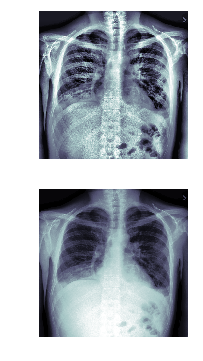

In [26]:
plots([image_adahist, image_eq])

In [27]:
from skimage.measure import shannon_entropy
from skimage import io, color, img_as_ubyte
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics.cluster import entropy




In [68]:

def s_entropy(dcm):
    return shannon_entropy(dcm)

def entropy_simple(dcm):
    return entropy(dcm)

class glcm:
    def __init__(self, image):
        distance = [1, 2, 3]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        self.image = img_as_ubyte(image.astype('int64'))
        self.glcm_mat = greycomatrix(self.image, distances = distance, angles = angles, symmetric = True, normed = True)
        self.properties = ['correlation', 'homogeneity', 'contrast', 'energy']
            
    def correlation(self):
        return greycoprops(self.glcm_mat, 'correlation').flatten()
    
    def homogeneity(self):
        return greycoprops(self.glcm_mat, 'homogeneity').flatten()
    
    def contrast(self):
        return greycoprops(self.glcm_mat, 'contrast').flatten()
    
    def energy(self):
        return greycoprops(self.glcm_mat, 'energy').flatten()
    
    def glcm_all(self):
        return np.hstack([greycoprops(self.glcm_mat, props).ravel() for props in self.properties])
    

In [69]:
entropy_simple(image_eq)

5.356776202157093

In [70]:
s_entropy(image_eq)

7.728194462004053

In [67]:
img_A = glcm(image_eq)
len(img_A.glcm_all())

48

In [62]:
img_glcm = glcm(image_eq)
img_cor = img_glcm.correlation()
img_cont = img_glcm.contrast()
img_ener = img_glcm.energy()
img_homo = img_glcm.homogeneity()

/usr/local/lib/python3.7/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.7/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


# Region Properties

In [139]:
def mean_from_list(listname):
    listname = pd.Series(listname).fillna(0).tolist()
    counts = 0
    total = 0
    for e in listname:
        if e != 0:
            counts = counts + 1
            total = total + e
    return total/counts

In [71]:
import math
from skimage.measure import label, regionprops

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

In [73]:
thresh_ada = threshold_otsu(image_adahist)

In [74]:
thresh_eq = threshold_otsu(image_eq)

In [75]:
thresh_ada, thresh_eq

(0.462890625, 0.5011160019785166)

In [78]:
bw_ada = closing(image_adahist > thresh_ada, square(3))

In [79]:
bw_eq = closing(image_eq > thresh_eq, square(3))

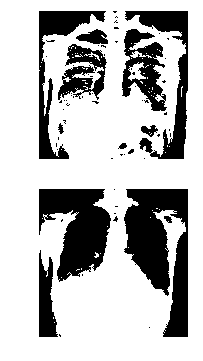

In [80]:
plots([bw_ada, bw_eq])

In [81]:
bw_clear_ada = clear_border(bw_ada)
bw_clear_eq = clear_border(bw_eq)

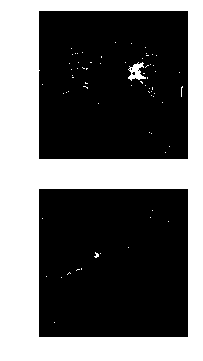

In [82]:
plots([bw_clear_ada, bw_clear_eq])

In [83]:
bw_label_ada = label(bw_clear_ada)
bw_label_eq = label(bw_clear_eq)

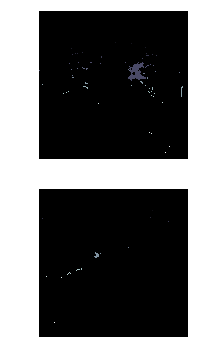

In [84]:
plots([bw_label_ada, bw_label_eq])

In [85]:
import matplotlib.patches as mpatches

In [86]:
region_label_ada = regionprops(bw_label_ada)

In [87]:
type(region_label_ada)

list

In [88]:
len(region_label_ada)

373

In [91]:
region_xx = region_label_ada[1]

In [121]:
region_xx.area, region_xx.eccentricity, region_xx.euler_number, region_xx.solidity, region_xx.perimeter

(2, 1.0, 1, 1.0, 0.0)

In [122]:
for x in region_label_ada:
    if x.area > 100:
        print(x.area)

127
8279
300
142
243
224
621
118


In [175]:
import statistics

In [188]:
# thresh_ada = threshold_otsu(image_adahist)
# bw_ada = closing(image_adahist > thresh_ada, square(3))
# bw_clear_ada = clear_border(bw_ada)

class region_props:
    def __init__(self, image):
        self.image = image
        self.thresh = threshold_otsu(self.image)
        self.bw = closing(self.image > self.thresh, square(3))
        self.bw_clear = clear_border(self.bw)
        self.bw_label = label(self.bw_clear)
        self.regions = regionprops(self.bw_label)
#         self.idx = 0
        
    def plot_image_bw(self):
        plt.imshow(self.bw, cmap = plt.cm.bone)
    
    def plot_image(self):
        plt.imshow(self.bw_clear, cmap=plt.cm.bone)
        
    def plot_image_with_labels(self):
        plt.imshow(self.bw_label, cmap=plt.cm.bone)
        
    def max_area(self):
        lista = []
        for e in self.regions:
            lista.append(e.area)
        idx = lista.index(max(lista))
        return max(lista)
    
    def eccentricity(self):
        
        lista = []
        for e in self.regions:
            lista.append(e.area)
        idx = lista.index(max(lista))
        return self.regions[idx].eccentricity
    
    def euler_number(self):
        lista = []
        for e in self.regions:
            lista.append(e.area)
        idx = lista.index(max(lista))
        return self.regions[idx].euler_number
    
    def solidity(self):
        lista = []
        for e in self.regions:
            lista.append(e.area)
        idx = lista.index(max(lista))
        return self.regions[idx].solidity
    
    def perimeter(self):
        lista = []
        for e in self.regions:
            lista.append(e.perimeter)
        return max(lista)
    
    def mean_area(self):
        lista = []
        for e in self.regions:
            lista.append(e.area)
        return statistics.mean(lista)
    
    def std_area(self):
        lista = []
        for e in self.regions:
            lista.append(e.area)
        return statistics.stdev(lista)
    
    def thresh_img(self):
        return self.thresh
        

In [187]:
region_props(image_eq).mean_area(), region_props(image_eq).std_area(), region_props(image_eq).thresh_img()

(14, 84.98823447983844, 0.5011160019785166)

In [181]:
region_props(image_eq).max_area(), region_props(image_eq).perimeter(), region_props(image_eq).eccentricity(), region_props(image_eq).euler_number(), region_props(image_eq).solidity()

/usr/local/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


(870, 184.675144212722, 0.39293189771135256, 1, 0.6258992805755396)

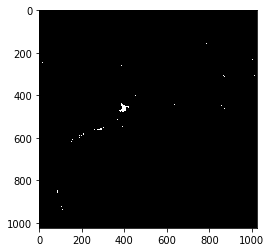

In [182]:
region_props(image_eq).plot_image()

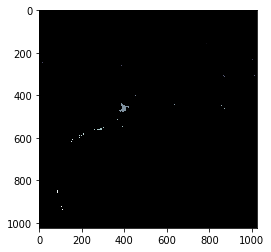

In [183]:
region_props(image_eq).plot_image_with_labels()

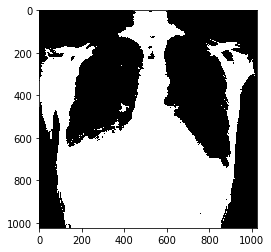

In [189]:
region_props(image_eq).plot_image_bw()

# Watershed Segmentation

In [190]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

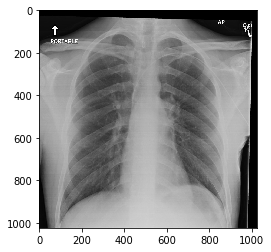

In [209]:
distance = ndi.distance_transform_edt(dcm[5])

local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)), labels=dcm[5])

markers = ndi.label(local_maxi)[0]

labels = watershed(-distance, markers, mask=dcm[5])

plt.imshow(dcm[5], cmap=plt.cm.gray)

# plt.imshow(-distance, cmap=plt.cm.gray)

# plt.imshow(labels, cmap=plt.cm.gray)

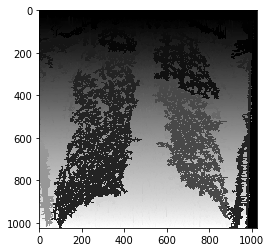

In [210]:
plt.imshow(labels, cmap=plt.cm.gray)

In [191]:
def water_seg(image, footprint = np.ones((3,3))):
    distance = ndi.distance_transform_edt(image)
    local_maxi = peak_local_max(distance, indices=False, footprint=footprint, labels=image)
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask = image)
    plt.imshow(labels, cmap=plt.cm.gray)

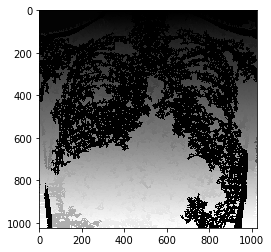

In [212]:
water_seg(dcm[100])

In [213]:
image = dcm[100]

# Moments and Hu-Moments

In [244]:
class moments:
    
    def __init__(self, image):
        self.image = image
        self.moment = cv2.moments(self.image)
        self.hu = cv2.HuMoments(self.moment)
        
    def get_moments(self):
        keys = [key for key in self.moment.keys()]
        values = [value for value in self.moment.values()]
        return keys, values
    
    def get_HuMoments(self):
        moments_hu = []
        for m in range(len(self.hu)):
            moments_hu.append(self.hu[m][0])
        return moments_hu

In [246]:
keys, values = moments(image).get_moments()

In [247]:
keys

['m00',
 'm10',
 'm01',
 'm20',
 'm11',
 'm02',
 'm30',
 'm21',
 'm12',
 'm03',
 'mu20',
 'mu11',
 'mu02',
 'mu30',
 'mu21',
 'mu12',
 'mu03',
 'nu20',
 'nu11',
 'nu02',
 'nu30',
 'nu21',
 'nu12',
 'nu03']

In [248]:
values

[122255295.0,
 60452125746.0,
 73744012952.0,
 37912242225178.0,
 36226563211389.0,
 53684556992544.0,
 2.675947005219563e+16,
 2.2285629262834756e+16,
 2.6366594795121416e+16,
 4.256430560634851e+16,
 8020207633055.047,
 -237970647769.875,
 9202398193084.695,
 81256769129104.0,
 -347576265377372.0,
 108036678117986.0,
 -919767695025840.0,
 0.0005365994904038461,
 -1.592164868626309e-05,
 0.0006156950551442949,
 4.916888448760498e-07,
 -2.1032016687520473e-06,
 6.537354369046877e-07,
 -5.565561126397063e-06]

In [249]:
moments(image).get_HuMoments()

[0.001152294545548141,
 7.270103949165659e-09,
 2.7130828775587278e-12,
 6.012191959355613e-11,
 -1.8343044418586418e-23,
 5.1072531579435435e-15,
 7.676386521496458e-22]